<a href="https://colab.research.google.com/github/Teakinboyewa/SEMANTIC-SEGMENTATION/blob/main/UNET_Semantic_Segmentation_for_green_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **U-NET SEMANTIC SEGMENTATION FOR GREEN AREA DETECTION ON SATELLITE IMAGERY**

# **INTRODUCTION**
This task demonstrate how we can build an image segmentation deep learning model which will predict the mask of a green space in a satellite imagery. The main objective of this project is to build a model which will be able to identify green space from a high-resolution satellite imagery. 
Google satellite imagery was obtained from google earth pro and was further converted to image chips. The segmentation models require a dataset of images and masks which delimit the object of interest. To achieve this, Label studio(https://labelstud.io/guide) was used in labelling the image chips and masks of each images were obtained. Vegetation (which represent trees, light vegetation, forest, woodland etc) was specified as the only label in label studio platform. Following that, the images and the resulting masks were properly arranged into folders and uploaded to google drive cloud storage for easy access. 

 


# **UNET ARCHITECTURE** 
UNet is one of the famous architectures used for image segmentation. According to Ronneberger et al. (2015), the U-net architecture uses the following types of layers and special operations
>(1) Conv2D, Simple convolution layers with padding and 3 × 3 kernel 

>(2) MaxPooling2D, Simple max-pooling layers with 2 × 2 kernel 

>(3) A cropping 2D, cropping layer used to crop feature maps and concatenate 

>(4) A concatenate layer used to concatenate multiple feature maps from different stages of training 

>(5) An UpSampling2D layer used to increase the size of the feature map. Then, the decoder part is implemented for up-sampling; and 

>(6) A softmax layer is added to generate a final segmentation

# **IMPORTING LIBRARIES**

In [53]:
import tensorflow as tf
import os
import sys
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

# **DATA PREPROCESSING**

In [54]:
seed = 42
np.random.seed = seed


Img_width = 128
Img_height = 128
Img_channels = 3  # rgb image


Train_Dir = '/content/drive/MyDrive/Vegetation_Dataset/train/' # Directory containing the training dataset 
Test_Dir = '/content/drive/MyDrive/Vegetation_Dataset/test/'  # Directory containg the testing dataset

Train_id = next(os.walk(Train_Dir))[1]
Test_id = next(os.walk(Test_Dir))[1]

X_train = np.zeros((len(Train_id), Img_height,Img_width, Img_channels), dtype = np.uint8)
Y_train = np.zeros((len(Train_id), Img_height,Img_width, 1), dtype = np.bool)

#print("No. of images = ", len(train_id))
#print("No. of images = ", len(test_id))
#print(X_train.shape)
#print (Y_train.shape)

print ('Resizing training images and mask')
for n, id in tqdm (enumerate(Train_id), total = len(Train_id)):
  path= Train_Dir + id
  img = imread(path +  '/image/' + id + '.png')[:,:,:Img_channels]
  img = resize (img, (Img_height, Img_width), mode='constant', preserve_range=True)
  X_train[n] = img
  mask = np.zeros ((Img_height, Img_width, 1), dtype = np.bool)
  for mask_file in next(os.walk(path + '/mask/'))[2]:
    mask_ = imread(path + '/mask/' + mask_file)
    mask_= np.expand_dims(resize(mask_, (Img_height, Img_width), mode='constant',
                                 preserve_range = True), axis = -1)
    mask = np.maximum (mask, mask_)
  
  Y_train[n] =mask

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Resizing training images and mask


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 20/20 [00:00<00:00, 37.28it/s]


In [55]:
# test images
X_test = np.zeros((len(Test_id), Img_height, Img_width, Img_channels), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(Test_id), total=len(Test_id)):
    path = Test_Dir + id_
    img = imread(path + '/image/' + id_ + '.png')[:,:,:Img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (Img_height, Img_width), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 20/20 [00:00<00:00, 100.33it/s]

Done!


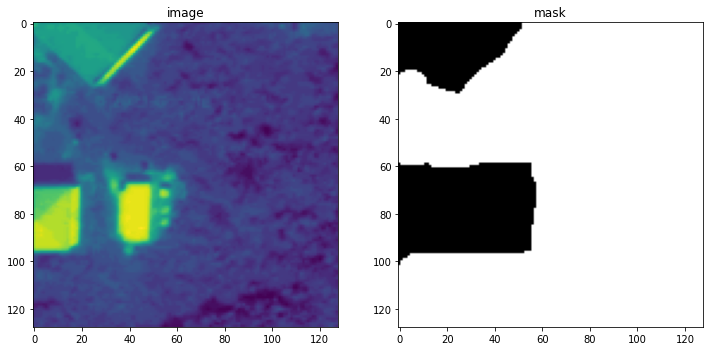

In [79]:
image_x = random.randint(0, len(Train_id))

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('image')
plt.imshow(X_train[image_x, :,:, 0])
plt.subplot(122)
plt.title('mask')
plt.imshow(Y_train[image_x, :,:,0], cmap='gray')
plt.show()


# **BUILDING UNET MODEL**

In [80]:
inputs = tf.keras.layers.Input((Img_width,Img_height,Img_channels)) 



a = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # converting input from integer to floating point

#contracting path
c1 = tf. keras.layers.Conv2D(16, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(a)
c1 = tf.keras.layers.Dropout(0.1)(c1) # dropping out 10%
c1 = tf. keras.layers.Conv2D(16, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf. keras.layers.Conv2D(32, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2) # dropping out 10%
c2 = tf. keras.layers.Conv2D(32, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)


c3 = tf. keras.layers.Conv2D(64, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3) # dropping out 10%
c3 = tf. keras.layers.Conv2D(64, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf. keras.layers.Conv2D(128, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4) # dropping out 10%
c4 = tf. keras.layers.Conv2D(128, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)


c5 = tf. keras.layers.Conv2D(256, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5) # dropping out 10%
c5 = tf. keras.layers.Conv2D(256, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c5)

# Expansive path
u6 = tf. keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same' )(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf. keras.layers.Conv2D(128, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6) # dropping out 10%
c6 = tf. keras.layers.Conv2D(128, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c6)



u7 = tf. keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same' )(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf. keras.layers.Conv2D(64, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7) # dropping out 10%
c7 = tf. keras.layers.Conv2D(64, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c7)




u8 = tf. keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same' )(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf. keras.layers.Conv2D(32, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8) # dropping out 10%
c8 = tf. keras.layers.Conv2D(32, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c8)


u9 = tf. keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same' )(c8)
u9 = tf.keras.layers.concatenate([u9,c1], axis = 3)
c9 = tf. keras.layers.Conv2D(16, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9) # dropping out 10%
c9 = tf. keras.layers.Conv2D(16, (3,3), activation ='relu', kernel_initializer = 'he_normal', padding='same' )(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)

model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

# **MODEL FITTING**

In [84]:
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('vegetation.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, validation_data=(X_test))

#history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=callbacks, validation_data=(X_test))


Epoch 1/50
2/2 [==============================] - 2s 312ms/step - loss: 0.5143 - accuracy: 0.6801 - val_loss: 0.4346 - val_accuracy: 0.8441
Epoch 2/50
2/2 [==============================] - 2s 296ms/step - loss: 0.5018 - accuracy: 0.6801 - val_loss: 0.4399 - val_accuracy: 0.8440
Epoch 3/50
2/2 [==============================] - 2s 295ms/step - loss: 0.4823 - accuracy: 0.6803 - val_loss: 0.4731 - val_accuracy: 0.8457
Epoch 4/50
2/2 [==============================] - 2s 296ms/step - loss: 0.4789 - accuracy: 0.6848 - val_loss: 0.3245 - val_accuracy: 0.8613
Epoch 5/50
2/2 [==============================] - 2s 294ms/step - loss: 0.4767 - accuracy: 0.6862 - val_loss: 0.4456 - val_accuracy: 0.9089
Epoch 6/50
2/2 [==============================] - 2s 295ms/step - loss: 0.4370 - accuracy: 0.7484 - val_loss: 0.3738 - val_accuracy: 0.9108
Epoch 7/50
2/2 [==============================] - 2s 297ms/step - loss: 0.4126 - accuracy: 0.7628 - val_loss: 0.3938 - val_accuracy: 0.8831
Epoch 8/50
2/2 [====

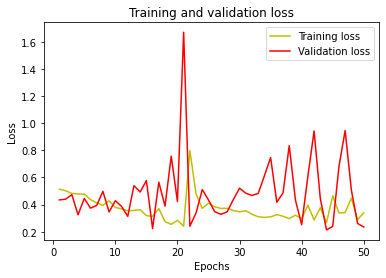

In [85]:
#plotting the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

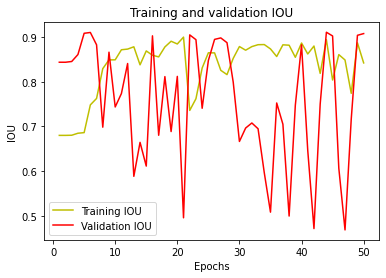

In [86]:
# Plotting the Training and validation IOU 
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']


plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

1/1 [==============================] - 0s 491ms/step


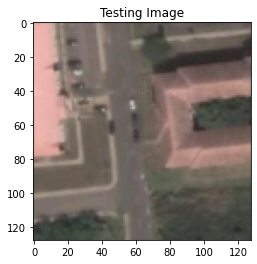

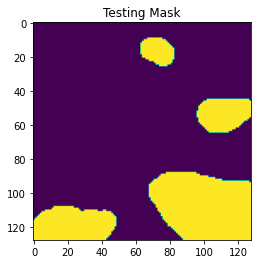

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


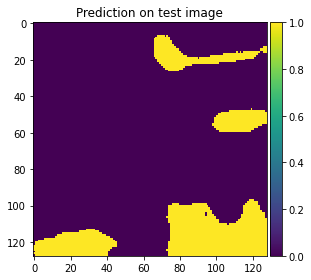

In [87]:
# Perform a sanity check on some random validation samples

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



ix = random.randint(0, len(preds_val_t))


plt.title("Testing Image")
plt.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()


plt.title("Testing Mask")
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()



plt.title("Prediction on test image")
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

